Create environment:

```python
mamba create -n confocal python=3.10 matplotlib numba scipy notebook
mamba activate confocal
mamba install cupy # if you want

pip install psfmodels
# this one isn't on PyPI yet... and really doesn't have a stable API at all
pip install git+https://github.com/tlambert03/microsim.git
```

In [1]:
# using the private _cuvec module because it can use cupy if available
# though the public API is not yet stable
from psfmodels._cuvec import vectorial_psf_centered
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import tqdm
import numpy as np
import torch

In [2]:
# convenience function we'll use a couple times
def ortho_plot(img, gamma: float = 0.5):
    """Plot XY and XZ slices of a 3D array."""
    _, ax = plt.subplots(ncols=2, figsize=(10, 5))
    ax[0].imshow(img[img.shape[0] // 2], norm=PowerNorm(gamma))
    ax[1].imshow(img[:, img.shape[1] // 2], norm=PowerNorm(gamma))
    ax[0].set_title("XY slice")
    ax[1].set_title("XZ slice")

There is a function to generate confocal PSFs in psfmodels `psfmodels.confocal_psf`...
but it's not setup to take advantage of the GPU, so is still slow.

The function below is much faster, and can be upstreamed eventually.

In [3]:
try:
    from cupyx.scipy.signal import fftconvolve
    import cupy as xp
except ImportError:
    import numpy as xp
    from scipy.signal import fftconvolve

def make_confocal_psf(ex_wvl=0.475, em_wvl=0.525, pinhole_au=1.0, **kwargs):
    """Create a confocal PSF.
    
    This function creates a confocal PSF by multiplying the excitation PSF with
    the emission PSF convolved with a pinhole mask.
    
    All extra keyword arguments are passed to `vectorial_psf_centered`.
    """
    kwargs.pop("wvl", None)
    params: dict = kwargs.setdefault("params", {})
    na = params.setdefault("na", 1.4)
    dxy = kwargs.setdefault("dxy", 0.01)

    print("making excitation PSF...")
    ex_psf = vectorial_psf_centered(wvl=ex_wvl, **kwargs)
    print("making emission PSF...")
    em_psf = vectorial_psf_centered(wvl=em_wvl, **kwargs)

    # The effective emission PSF is the regular emission PSF convolved with the
    # pinhole mask. The pinhole mask is a disk with diameter equal to the pinhole
    # size in AU, converted to pixels.
    pinhole = _pinhole_mask(
        nxy=ex_psf.shape[-1], pinhole_au=pinhole_au, wvl=em_wvl, na=na, dxy=dxy
    )
    pinhole = xp.asarray(pinhole)

    print("convolving em_psf with pinhole...")
    eff_em_psf = np.empty_like(em_psf)
    for i in tqdm.trange(len(em_psf)):
        plane = fftconvolve(xp.asarray(em_psf[i]), pinhole, mode="same")
        eff_em_psf[i] = plane.get() if hasattr(plane, 'get') else plane

    # The final PSF is the excitation PSF multiplied by the effective emission PSF.
    return ex_psf * eff_em_psf

def _pinhole_mask(nxy: int, pinhole_au: float, wvl: float, na: float, dxy: float):
    """Create a 2D circular pinhole mask of specified `pinhole_au`."""
    pinhole_size = pinhole_au * 0.61 * wvl / na
    pinhole_px = pinhole_size / dxy

    x = xp.arange(nxy) - nxy // 2
    xx, yy = xp.meshgrid(x, x)
    r = xp.sqrt(xx**2 + yy**2)
    return (r <= pinhole_px).astype(int)


/home/anirban.ray/miniconda3/envs/pytorch/lib/python3.9/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


... and here's a variant using a pinhole of 1AU

In [7]:
psf_list = []
#aus = np.linspace(0.5, 5.75, 22)
aus = [0.5, 1.25, 2.0, 2.75, 3.5, 4.25, 5.0, 5.75]
for pinhole_au in aus:
    psf = make_confocal_psf(
        ex_wvl=0.475,
        em_wvl=0.525,
        pinhole_au=pinhole_au,
        nz=256,
        nx=768,
        dz=0.02,
        dxy=0.01,
        params={"na": 1.4},
    )
    psf_list.append(psf)
#ortho_plot(psf_list[0])

#psf_list = np.load('/group/jug/Anirban/Datasets/TalleySim_96/PSF/psf.npy') #contains all the PSFs for T=[0,22] saved in the disk

making excitation PSF...
making emission PSF...
convolving em_psf with pinhole...


100%|██████████| 256/256 [00:01<00:00, 139.25it/s]


making excitation PSF...
making emission PSF...
convolving em_psf with pinhole...


100%|██████████| 256/256 [00:01<00:00, 142.90it/s]


making excitation PSF...
making emission PSF...
convolving em_psf with pinhole...


100%|██████████| 256/256 [00:01<00:00, 139.70it/s]


making excitation PSF...
making emission PSF...
convolving em_psf with pinhole...


100%|██████████| 256/256 [00:01<00:00, 150.12it/s]


making excitation PSF...
making emission PSF...
convolving em_psf with pinhole...


100%|██████████| 256/256 [00:01<00:00, 148.88it/s]


making excitation PSF...
making emission PSF...
convolving em_psf with pinhole...


100%|██████████| 256/256 [00:01<00:00, 143.12it/s]


making excitation PSF...
making emission PSF...
convolving em_psf with pinhole...


100%|██████████| 256/256 [00:01<00:00, 148.77it/s]


making excitation PSF...
making emission PSF...
convolving em_psf with pinhole...


100%|██████████| 256/256 [00:01<00:00, 143.17it/s]


Now, all we need to do to create an image is to convolve the PSF with
some ground truth sample.  Here's where we can get creative...

To start with, here's some lines in random 3D orientations and lengths
(I call it "mats lines" because it's similar to a pattern mats gustafsson used 
in the supplement of a paper)

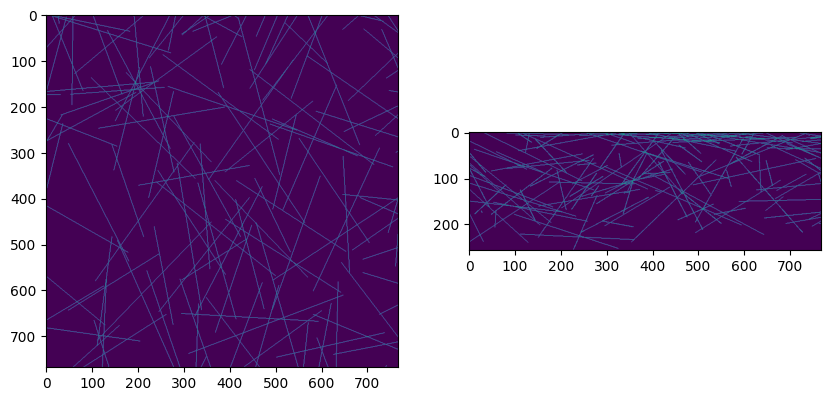

In [10]:
from microsim.samples import MatsLines
ary = np.zeros((256, 2048, 2048)) #larger image
mats = MatsLines(density=0.4, length=300, azimuth=5, max_r=1.5, background=0.1, background_type="none") #[background_type="none", "uniform", "constant"]
truth = mats.render(ary)
#make a random crop of the truth of size 256x768x768
rand = np.random.randint(0, 2048-768, 2)
truth = truth[:, rand[0]:rand[0]+768, rand[1]:rand[1]+768]


# plot max projection
_, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].imshow(truth.max(axis=0))
axs[1].imshow(truth.max(axis=1))
plt.show()


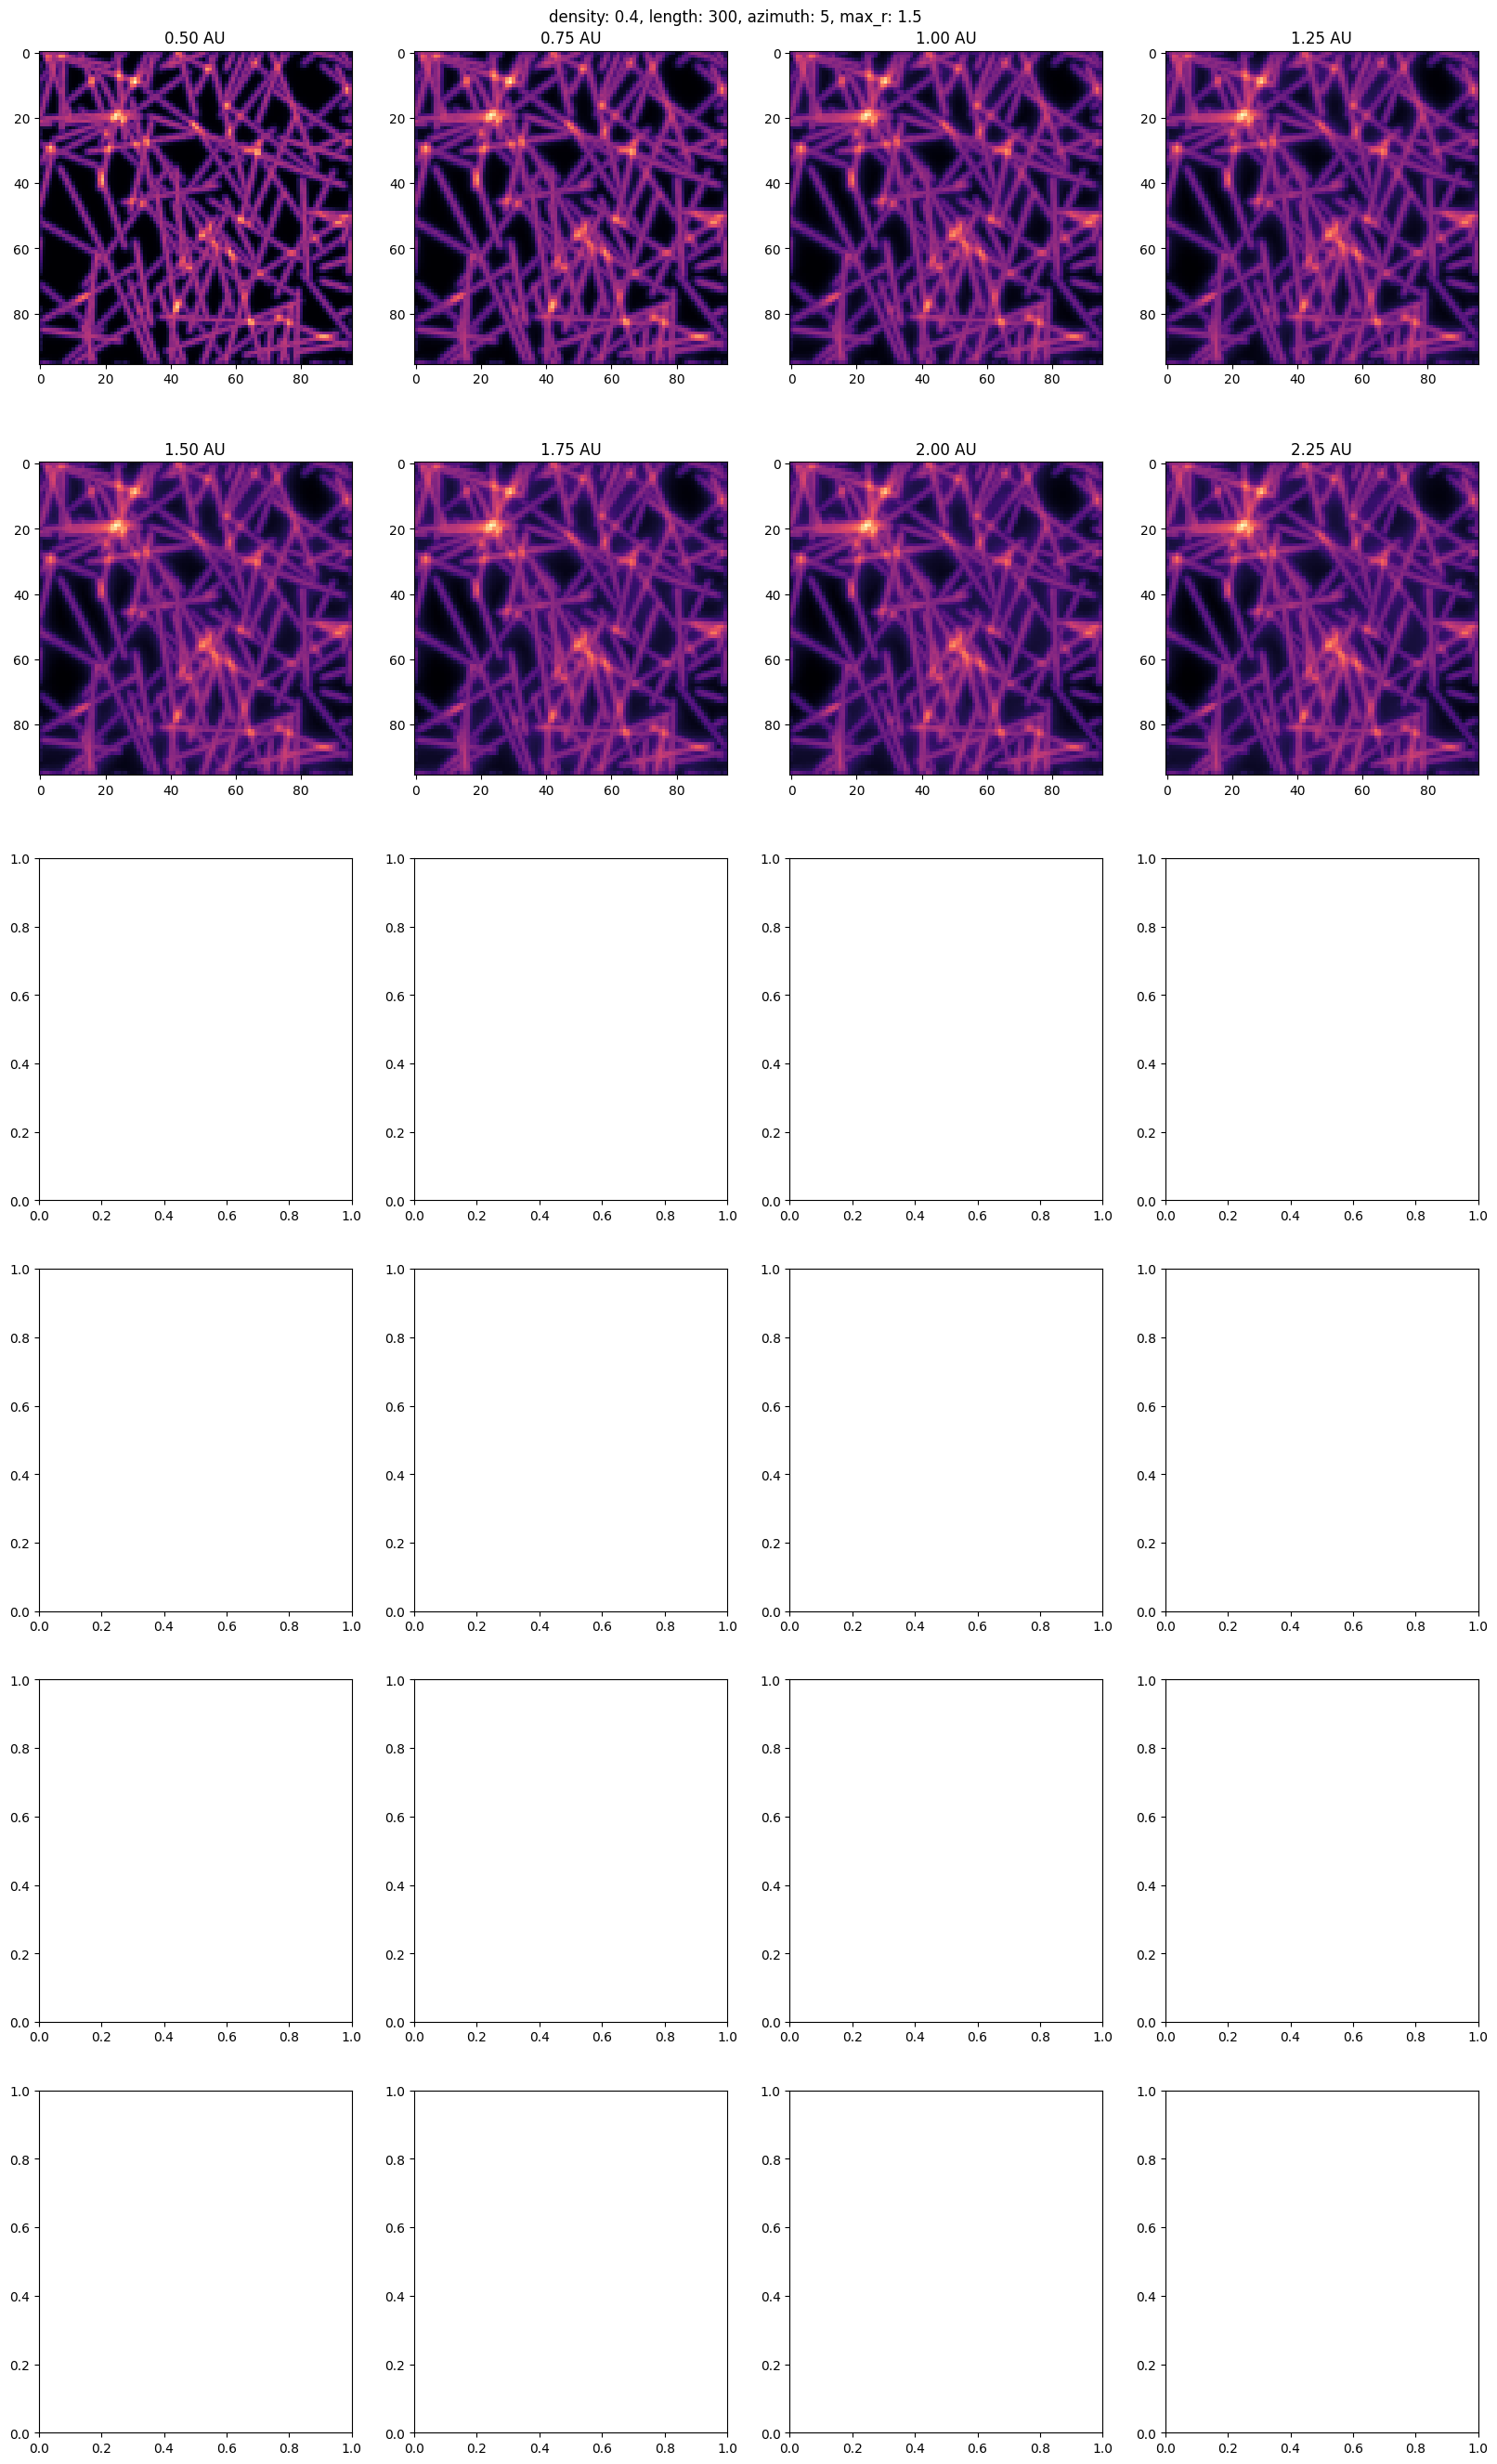

In [11]:
from scipy import signal
# same thing, but for the confocal PSF
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def downsample(array: np.ndarray, factor: int or Sequence[int], method=np.sum, dtype=None) -> np.ndarray:
    binfactor = (factor,) * array.ndim if isinstance(factor, int) else factor
    new_shape = []
    for s, b in zip(array.shape, binfactor):
        new_shape.extend([s // b, b])
    reshaped = np.reshape(array, new_shape)
    for d in range(array.ndim):
        reshaped = method(reshaped, axis=-1 * (d + 1), dtype=dtype)
    return reshaped


def generate_image_torch(truth, psf):
    truth = torch.tensor(truth, device=device)
    psf_au = torch.tensor(psf, device=device)
    truth_fft = torch.fft.rfftn(truth)
    psf_au_fft = torch.fft.rfftn(psf_au)
    img_confocal = torch.fft.irfftn(truth_fft  * psf_au_fft)
    img_confocal = torch.fft.fftshift(img_confocal, dim=[1,2])
    img_confocal = img_confocal.cpu().numpy()
    downsampled_img = downsample(img_confocal, 8)
    downsampled_img = downsampled_img.astype(np.float32)
    downsampled_img = downsampled_img.max(axis=0)
    downsampled_img = (downsampled_img - np.min(downsampled_img)) / np.max(downsampled_img)
    return downsampled_img

generated_images = []
for psf_1au in psf_list:
    img_confocal = generate_image_torch(truth, psf_1au)
    #normalize img_confocal to [0, 1]
    #img_confocal = (img_confocal - np.min(img_confocal)) / np.max(img_confocal)
    generated_images.append(img_confocal)
pinhole_sizes = np.linspace(0.5, 5.75, 22)
#plot all generated images 5 in a row
_, axs = plt.subplots(ncols=4, nrows=6, figsize=(20, 30))
plt.suptitle(f"density: {mats.density}, length: {mats.length}, azimuth: {mats.azimuth}, max_r: {mats.max_r}")
#remove all whitespace after sup title
plt.subplots_adjust(top=0.97)
for i, img in enumerate(generated_images):
    axs[i//4, i%4].imshow(img, cmap='magma')
    title = f"{pinhole_sizes[i]:.2f} AU"
    axs[i//4, i%4].set_title(title)
plt.show()

#convert to numpy and save as tiff
from tifffile import imwrite
generated_images = np.array(generated_images)
imwrite(f'density_{mats.density}_length_{mats.length}_azimuth_{mats.azimuth}_max_r_{mats.max_r}_bg_{mats.background}_bgType_{mats.background_type}_.tif', generated_images)